# wavelet-partition
tool to partition FLUXNET-CH4 data into diffusive and ebullitive fluxes

In [1]:
import pandas as pd
import numpy as np
import pywt
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

set global matplotlib settings

In [2]:
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') # global plotting settings

## Import data and process

FLUXNET-CH4 data stored on google drive, split google drive url and import with pandas

In [3]:
def pd_read_from_drive(site_id='FLX_JP-Swl'):
    '''reads csv from google drive url into pandas dataframe'''''
    if site_id == 'FLX_JP-Swl': # urls could be stored as a dict {site_id : url}
        url = "https://drive.google.com/file/d/1Pudof9T3_TOxpd5eY2F9ZjyvGxFub4Rg/view?usp=sharing"
    elif site_id == 'FLX_JP-BBY':
        url = "https://drive.google.com/file/d/1bMn9xCFZJ8Z1xVZmJ-Z8Xu0AH8xskyYs/view?usp=sharing"
    else: 
        raise ValueError("not a valid site_id!") # could be KeyError with dict
    file_id=url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?id=' + file_id
    return pd.read_csv(dwn_url)

## JP-Swl

read, replace missing, parse timestamp

In [4]:
df = pd_read_from_drive('FLX_JP-Swl') # read
df = df.replace(-9999, np.nan) # replace missing with nan
df["date"] = pd.to_datetime(df["TIMESTAMP_START"], format='%Y%m%d%H%M') # parse timestamp to new column 'date'

### Find portion to partition

select all rows from selected columns

In [5]:
df = df.loc[:, ['date', "LE", "FCH4", "TA", "FCH4_F", "TA_F"]]

plot entire FCH4 series vs time

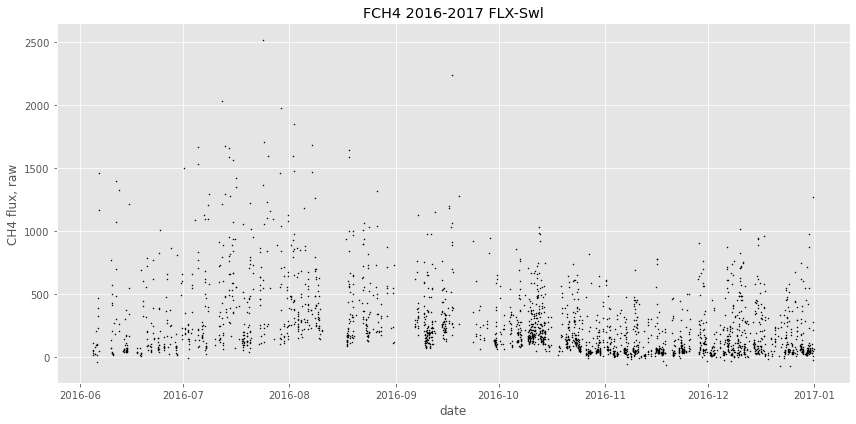

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['date'], df['FCH4'], c='k', s=1)
ax.set_ylabel("CH4 flux, raw")
ax.set_xlabel("date")
ax.set_title("FCH4 2016-2017 FLX-Swl")
plt.tight_layout()

limit date range, into new Dataframe data

(roughly 2016-06-01 to 2016-08-15 looks relatively continuous)

In [7]:
dfw = df[((df['date'] >= '2016-01-01') & (df['date'] <= '2016-08-11'))]

plot FCH4 and FCH4_F

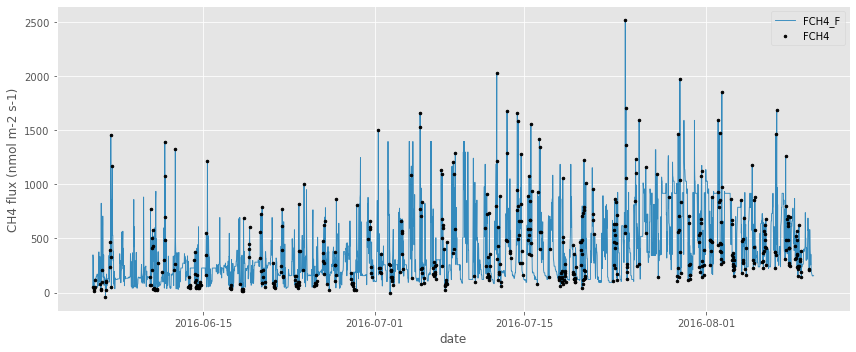

In [8]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(dfw['date'], dfw['FCH4_F'], list(plt.rcParams['axes.prop_cycle'])[1]['color'], 
        dfw['date'], dfw['FCH4'], 'k.', markersize=5, linewidth=0.9)
ax.set_xlabel('date')
ax.set_ylabel('CH4 flux (nmol m-2 s-1)')
ax.legend(['FCH4_F', 'FCH4']) # not sure why this order, this is workaround
plt.tight_layout()

gap-filling is adding some serious fluctuations in gaps of seemingly days? I want to trim that big gap ~06-06 to 06-09 and pad with pandas

better way to zoom would be to find first non-nan value in FCH4 vector and corresponding date

edit: Series.first_valid_index() returns index of first non-nan (.last_... returns last)

In [9]:
dfw = df[df['FCH4'][df['date'] >= '2016-06-08'].first_valid_index():df['FCH4'][df['date'] <= '2016-08-15'].last_valid_index()]
dfw

,date,LE,FCH4,TA,FCH4_F,TA_F
7730,2016-06-10 01:00:00,103.830,140.5160,16.9372,140.51600,16.937
7731,2016-06-10 01:30:00,95.856,69.4765,16.8077,69.47650,16.808
7732,2016-06-10 02:00:00,94.305,774.4370,16.6534,774.43700,16.653
7733,2016-06-10 02:30:00,NaN,NaN,16.5118,132.35611,16.512
7734,2016-06-10 03:00:00,NaN,NaN,16.3884,139.52093,16.388
...,...,...,...,...,...,...
10680,2016-08-10 12:00:00,125.950,NaN,26.0310,571.27260,26.031
10681,2016-08-10 12:30:00,137.250,NaN,26.7014,585.79364,26.701
10682,2016-08-10 13:00:00,176.230,NaN,27.3151,507.38342,27.315
10683,2016-08-10 13:30:00,260.440,NaN,27.5956,246.33500,27.596


verify that we chopped that first big gap

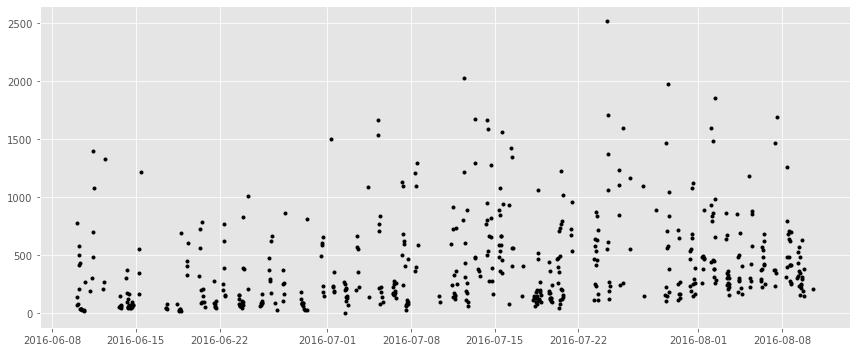

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dfw['date'], dfw['FCH4'], 'k.')
plt.tight_layout()

### Gap-filled sanity check

compute wavelet transform on gap-filled data in dfw (df between 06-10 and 08-10)

In [11]:
cMF = pd.DataFrame(pywt.wavedec(df['FCH4_F'], 'haar')).transpose()
cTF = pd.DataFrame(pywt.wavedec(df['TA_F'], 'haar')).transpose()

scatter of wavelet coefficients

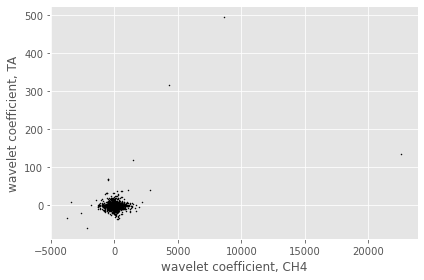

In [12]:
fig, ax = plt.subplots()

for i in range(cMF.shape[1]):
    ax.scatter(cMF[i], cTF[i], c='k', s=1)
plt.xlabel("wavelet coefficient, CH4")
plt.ylabel("wavelet coefficient, TA")
plt.tight_layout()

limit plot window

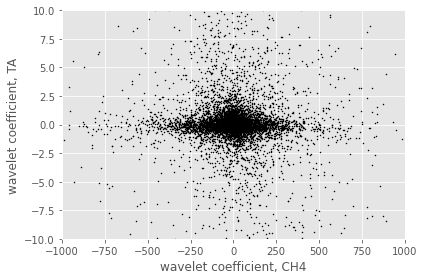

In [13]:
fig, ax = plt.subplots()

for i in range(cMF.shape[1]):
    ax.scatter(cMF[i], cTF[i], c='k', s=1)
plt.xlabel("wavelet coefficient, CH4")
plt.ylabel("wavelet coefficient, TA")
plt.xlim(-1000, 1000)
plt.ylim(-10, 10)
plt.tight_layout()

normalize gap-filled data by mean over summer
- FCH4_F not normal dist with overall dfw mean
- much more normal with rolling mean, window size 96 (two days)
- TA more normal with overall dfw mean

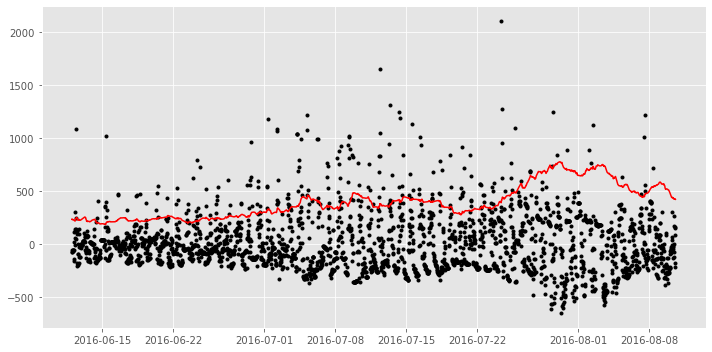

In [36]:
# applying summer mean to entire series! nonsense data outside of dfw date range
# need to figure out .loc usage (view vs copy, SettingWithCopy error)
# need to redefine dfw here? something wrong

dfw = df[df['FCH4'][df['date'] >= '2016-06-08'].first_valid_index():df['FCH4'][df['date'] <= '2016-08-15'].last_valid_index()]

df['FCH4_Fn'] = df['FCH4_F'] - dfw['FCH4_F'].rolling(96).mean()
df['TA_Fn'] = df['TA_F'] - dfw['TA_F'].rolling(96).mean()
# print(df['FCH4_Fn', 'TA_Fn'])

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dfw['date'], dfw['FCH4_Fn'], 'k.',
       dfw['date'], dfw['FCH4_F'].rolling(96).mean(), 'r-')
plt.tight_layout()

compute DWT at maximum useful levels (pywt computes max freq resolution)

In [37]:
cMFn = pd.DataFrame(pywt.wavedec(dfw['FCH4_Fn'], 'haar')).transpose()
cTFn = pd.DataFrame(pywt.wavedec(dfw['TA_Fn'], 'haar')).transpose()

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


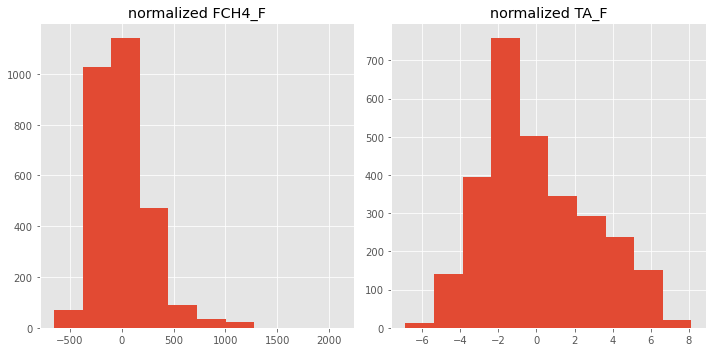

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(dfw['FCH4_Fn'])
ax[0].set_title('normalized FCH4_F')
ax[1].hist(dfw['TA_Fn'])
ax[1].set_title('normalized TA_F')
plt.tight_layout()

scatter of wavelet coefficients

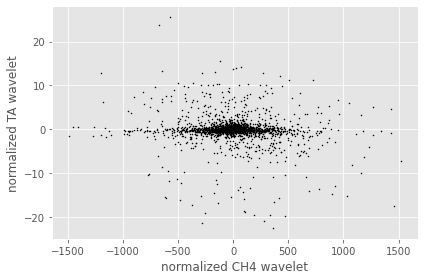

In [39]:
fig, ax = plt.subplots()

for i in range(cMFn.shape[1]):
    ax.scatter(cMFn[i], cTFn[i], c='k', s=1)
plt.xlabel("normalized CH4 wavelet")
plt.ylabel("normalized TA wavelet")
plt.tight_layout()

limit plot window

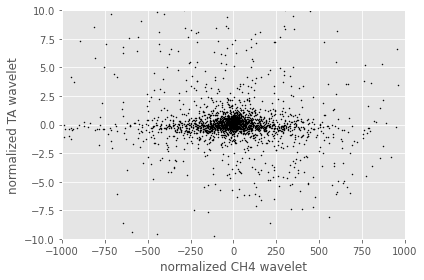

In [43]:
fig, ax = plt.subplots()

for i in range(cMFn.shape[1]):
    ax.scatter(cMFn[i], cTFn[i], c='k', s=1)
plt.xlabel("normalized CH4 wavelet")
plt.ylabel("normalized TA wavelet")
plt.tight_layout()

plt.xlim(-1000, 1000)
plt.ylim(-10, 10)
plt.tight_layout()

### Manual Padding

forward-pad nans to new column "FCH4_P"

In [120]:
num_pad = 4 
for i in range(num_pad):
    df['FCH4_P{}'.format(i+1)] = df["FCH4"].fillna(method="pad", limit=i+1)

plot comparing padded series

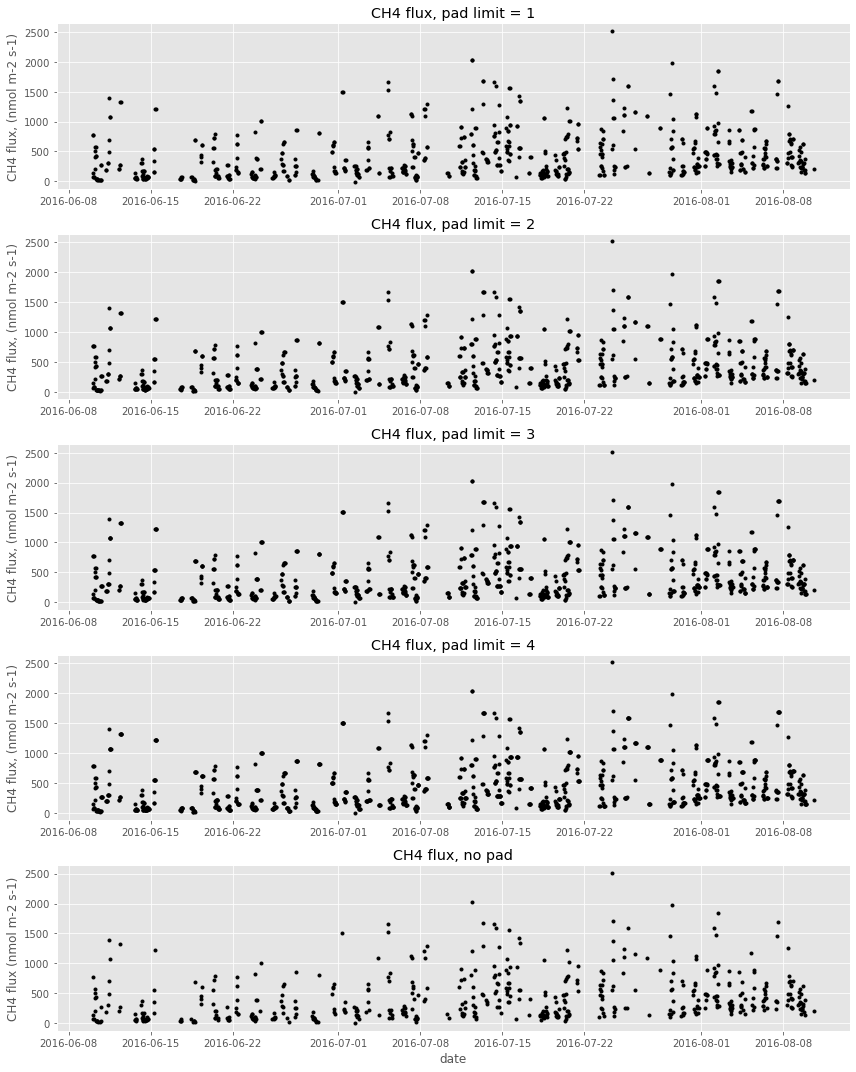

In [125]:
fig, ax = plt.subplots(num_pad+1, 1, sharey=True, figsize=(12,15))

for i in range(num_pad):
    ax[i].plot(dfw['date'], dfw['FCH4_P{}'.format(i+1)], 'k.')
    ax[i].set(ylabel='CH4 flux, (nmol m-2 s-1)', title='CH4 flux, pad limit = {}'.format(i+1))

ax[num_pad].plot(dfw['date'], dfw['FCH4'], 'k.')
ax[num_pad].set(xlabel='date', ylabel='CH4 flux (nmol m-2 s-1)', 
                title='CH4 flux, no pad')
plt.tight_layout()

misguided? defunct? find continuous measurements, group_by cumsum of isna(), bigger groups are longer continuous chunks


In [123]:
# dfw['group_no'] = dfw['FCH4'].isna().cumsum()

# dfg = df.groupby('group_no').filter(lambda x: len(x) == 1)
# d = {i: df.loc[df.group_no == i, ['date', 'FCH4']] 
#      for i in range(1, df.group_no.iat[-1])}
# # ds = pd.DataFrame(d)

plot histogram of gap lengths for different pad limits

# junk / test

scatter FCH4_F and FCH4 vs time

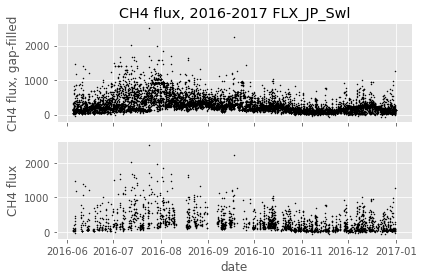

In [89]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
ax[0].scatter(df['date'], df['FCH4_F'], c='k', s=1)
ax[0].set_ylabel("CH4 flux, gap-filled")
ax[0].set_title("CH4 flux, 2016-2017 FLX_JP_Swl")

ax[1].scatter(df['date'], df['FCH4'], c='k', s=1)
ax[1].set_ylabel("CH4 flux")
ax[1].set_xlabel("date")
plt.tight_layout()

compute wavelet transform on gap-filled data

In [6]:
cM = pd.DataFrame(pywt.wavedec(df['FCH4_F'], 'haar')).transpose()
cT = pd.DataFrame(pywt.wavedec(df['TA_F'], 'haar')).transpose()

scatter of wavelet coefficients

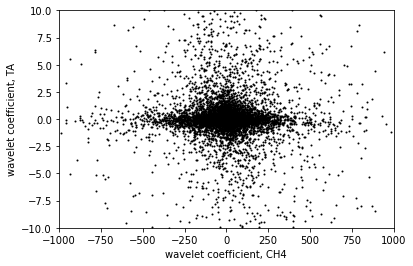

In [142]:
fig, ax = plt.subplots()

for i in range(cM.shape[1]):
    ax.scatter(cM[i], cT[i], c='k', s=1)
plt.xlabel("wavelet coefficient, CH4")
plt.ylabel("wavelet coefficient, TA")
plt.xlim(-1000, 1000)
plt.ylim(-10, 10)
plt.show()

scatter of FCH4 and TA vs time

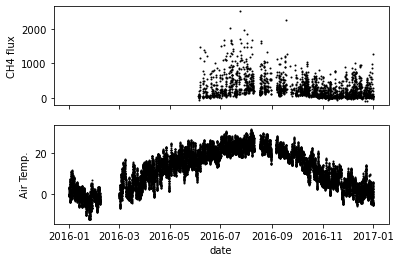

In [143]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False)

axs[0].scatter(df['date'], df['FCH4'], c='k', s=1)
axs[0].set_ylabel('CH4 flux')

axs[1].scatter(df['date'], df['TA'], c='k', s=1)
axs[1].set_ylabel('Air Temp.')
axs[1].set_xlabel('date')
plt.show()